In [81]:
"""
Resources:
* https://youtu.be/aircAruvnKk
* http://neuralnetworksanddeeplearning.com/
* playground.tensorflow.org
"""
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


from tqdm import tqdm
from IPython import display

#some common activation functions---

def ReLu(x):
    mask = (x>0) * 1.0
    return mask *x
def d_ReLu(x):
    mask = (x>0) * 1.0
    return mask 

def arctan(x):
    return np.arctan(x)
def d_arctan(x):
    return 1 / (1 + x ** 2)

def log(x):
    return 1 / ( 1+ np.exp(-1*x))
def d_log(x):
    return log(x) * (1 - log(x))

def tanh(x):
    return np.tanh(x)
def d_tanh(x):
    return 1 - np.tanh(x) ** 2

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys')

    return fig



def activation(z, derivative=False):
    if derivative:
        return activation(z) * (1 - activation(z))
    else:
        return 1 / (1 + np.exp(-z))
def cost_function_discriminant(a,b):
    cost_d=-np.log(a) + np.log(1.0- b)
    return cost_d
def cost_function_generator(a):
    cost_g=-np.log(a)
    return cost_g
    random_int = np.random.randint(len(images) - 5)
    present_image = np.expand_dims(X[random_int],axis=0)

def cost_function(y_true, y_pred):
    

    if y_true.shape!=y_pred.shape:
                y_pred=y_pred.T
    n = y_pred.shape[0]
    cost = (1./(2*n)) * np.sum((y_true - y_pred) ** 2)
    return cost

def cost_function_prime(y_true, y_pred):

    cost_prime = y_pred - y_true
    
    return cost_prime.T



class NeuralNetwork(object):     


    def __init__(self, size, seed=42):
        '''
        Instantiating the weights and biases of the network
        weights and biases are attributes of the NeuralNetwork class
        They are updated during the training
        '''
        self.seed = seed
        np.random.seed(self.seed)
        self.size = size
        self.weights = [np.random.randn(self.size[i], self.size[i-1]) * np.sqrt(1 / self.size[i-1]) for i in range(1, len(self.size))]
        self.biases = [np.random.rand(n, 1) for n in self.size[1:]]
        # TODO3-done
        #For GAN---
        Generator_input = 1000
        
        self.Discriminator_Weight_1 = np.random.normal(size=(784,1),scale=(1. / np.sqrt(784 / 2.)))   *0.002
        self.Discriminator_bias_1 = np.zeros(1)


        self.Generator_Weight1 = np.random.normal(size=(Generator_input,784),scale=(1. / np.sqrt(Generator_input / 2.)))  *0.002
        self.Generator_bias1 = np.zeros(784)

    def forward(self, input):
       
        a = input
        pre_activations = []
        activations = [a]
         # TODO
        #todo4 - done
        # what does the zip function do?
        #ans-zip is basically mapping similar index of multiple containers so that they can be used just using as single entity.
        #so here updating the a by doing a dot product of activation of layer1 with the weights of connectins
        #and adding a "bias" and then activating it by applying the sigmoid function to it.
        #pre activation is the array of z before applying sigmoid function to it
        for w, b in zip(self.weights, self.biases):
            w_shape=w.shape
            a_shape=a.shape
            if w_shape[1]!=a_shape[0]:
                a=a.T
            z = np.dot(w, a) + b
            a  = activation(z)
            pre_activations.append(z)
            activations.append(a)
        return a.T, pre_activations, activations

    def compute_deltas(self, pre_activations, y_true, y_pred):
       
        delta_L = cost_function_prime(y_true, y_pred) * activation(pre_activations[-1], derivative=True)
        deltas = [0] * (len(self.size) - 1)
        deltas[-1] = delta_L
        for l in range(len(deltas) - 2, -1, -1):
            delta = np.dot(self.weights[l + 1].transpose(), deltas[l + 1]) * activation(pre_activations[l], derivative=True) 
            deltas[l] = delta
        return deltas

    def backpropagate(self, deltas, pre_activations, activations):
        dW = []
        db = []
        deltas = [0] + deltas
        for l in range(1, len(self.size)):
            if deltas[l].shape[1] != activations[l-1].shape[0]:
                activations[l-1]=activations[l-1].T
            dW_tempp = np.dot(deltas[l], activations[l-1]) 
            db_tempp = deltas[l]
            dW.append(dW_tempp)
            db.append(np.expand_dims(db_tempp.mean(axis=1), 1))
        return dW, db

    def plot_decision_regions(self, X, y, iteration, train_loss, val_loss, train_acc, val_acc, res=0.01):

        X, y = X.T, y.T 
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, res),
                            np.arange(y_min, y_max, res))
        
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()].T)
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.5)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.scatter(X[:, 0], X[:, 1], c=y.reshape(-1),  alpha=0.2)
        message = 'iteration: {} | train loss: {} | val loss: {} | train acc: {} | val acc: {}'.format(iteration,
                                                                                                     train_loss, 
                                                                                                     val_loss, 
                                                                                                     train_acc, 
                                                                                                     val_acc)
        plt.title(message)

    

    def train(self, X, y_org, batch_size, epochs, learning_rate, beta_1, beta_2, eps, print_every=10, tqdm_=True, plot_every=None):
        a1,b1 = 0,0
        a2,b2 = 0,0

        a3,b3 = 0,0
        a4,b4 = 0,0

        Generator_input = 1000
        
        
        Discriminator_Weight_1 =self.Discriminator_Weight_1
        Discriminator_bias_1 =self.Discriminator_bias_1 

        Generator_Weight1 =self.Generator_Weight1
        Generator_bias1 =self.Generator_bias1 
        
        temp_y=np.copy(y_org)
        history_train_losses = []
        history_train_accuracies = []
        history_test_losses = []
        history_test_accuracies = []
        s=temp_y.tolist()
        
        import random
        E = numpy.random.rand(28 * 28 * 2)
        #reshaping
        E = E.reshape((2, 28, 28, 1))
        for i in range(2):
            img = E[i].reshape((28,28))
            plt.figure(figsize=(2,2))
            figure=plt.imshow(img, cmap="Greys")
        #one_hot encoding
        for u in range(len(temp_y)):
            if s[u]==0:
                s[u]=[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
            if s[u]==1:
                s[u]=[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]
            if s[u]==2:
                s[u]=[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]
            if s[u]==3:
                s[u]=[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
            if s[u]==4:
                s[u]=[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]
            if s[u]==5:
                s[u]=[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]
            if s[u]==6:
                s[u]=[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]
            if s[u]==7:
                s[u]=[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]
            if s[u]==8:
                s[u]=[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]
            if s[u]==9:
                s[u]=[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]
        y=np.array(s)
        #todo8- done     

        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        
        if tqdm_:
            epoch_iterator = tqdm(range(epochs))
        else:
            epoch_iterator = range(epochs)

        for h in epoch_iterator:
            #for dicrimant
            #start
            random_int = np.random.randint(len(x_train) - 5)
            present_image = np.expand_dims(x_train[random_int],axis=0)

            #initializing fake data
            import random
            np.random.seed(2)
            
            Z = np.random.uniform(-1., 1., size=[1, Generator_input])
            Generator_layer_1 = Z.dot(Generator_Weight1) + Generator_bias1
            Generator_layer_1_A = arctan(Generator_layer_1)

            present_fake_data = log(Generator_layer_1)

            if present_image.shape[1]!=Discriminator_Weight_1.shape[0]:
                Discriminator_Weight_1=Discriminator_Weight_1.T
            Discriminator_layer_1_r = present_image.dot(Discriminator_Weight_1) + Discriminator_bias_1
            Discriminator_layer_1_rA = ReLu(Discriminator_layer_1_r)

            # Func: Forward Feed for Fake Data
            if  present_fake_data.shape[1]!=Discriminator_Weight_1.shape[0]:
                Discriminator_Weight_1=Discriminator_Weight_1.T
            Discriminator_layer_1_f = present_fake_data.dot(Discriminator_Weight_1) + Discriminator_bias_1
            Discriminator_layer_1_fA = ReLu(Discriminator_layer_1_f)

            D_cost = cost_function_discriminant(Discriminator_layer_1_rA,Discriminator_layer_1_fA)

            grad_fake_weight1_a =  1/(1.0- Discriminator_layer_1_fA)
            grad_fake_weight1_b =  d_log(Discriminator_layer_1_f)
            grad_fake_weight1_c =   Discriminator_layer_1_fA
            grad_fake_weight1 = grad_fake_weight1_c.T.dot(grad_fake_weight1_a * grad_fake_weight1_b) 
            grad_fake_bias1 = grad_fake_weight1_a * grad_fake_weight1_b

            grad_real_weight1_a =  - 1/Discriminator_layer_1_rA
            grad_real_weight1_b =  d_log(Discriminator_layer_1_r)
            grad_real_weight1_c =   Discriminator_layer_1_rA
            grad_real_weight1 =       grad_real_weight1_c.T.dot(grad_real_weight1_a * grad_real_weight1_b) 
            grad_real_bias1 =       grad_real_weight1_a * grad_real_weight1_b

            grad_weight1 =grad_fake_weight1 + grad_real_weight1
            grad_bias1 =grad_fake_bias1 + grad_real_bias1
            #updating gradient
            b1 = beta_1 * b1 + (1 - beta_1) * grad_weight1
            a1 = beta_2 * a1 + (1 - beta_2) * grad_weight1 ** 2

            a2 = beta_1 * b2 + (1 - beta_1) * grad_bias1
            a2 = beta_2 * a2 + (1 - beta_2) * grad_bias1 ** 2

            Discriminator_Weight_1 = Discriminator_Weight_1 - (learning_rate / (np.sqrt(a1 /(1-beta_2) ) + eps)) * (b1/(1-beta_1))
            Discriminator_bias_1 = Discriminator_bias_1 - (learning_rate / (np.sqrt(a2 /(1-beta_2) ) + eps)) * (b2/(1-beta_1))

            #forward-generator
            Z = np.random.uniform(-1., 1., size=[1, Generator_input])
            Generator_layer_1 = Z.dot(Generator_Weight1) + Generator_bias1
            Generator_layer_1_A = arctan(Generator_layer_1)

            present_fake_data = log(Generator_layer_1)

            Discriminator_layer_1 = present_fake_data.dot(Discriminator_Weight_1) + Discriminator_bias_1
            Discriminator_layer_1_A = ReLu(Discriminator_layer_1)
            G_cost = cost_function_generator(Discriminator_layer_1_A)

            if  d_log(Discriminator_layer_1).shape[1]!=Discriminator_Weight_1.T.shape[0]:
                Discriminator_Weight_1.T=Discriminator_Weight_1
            if  (d_ReLu(Discriminator_layer_1)).shape[1]!=Discriminator_Weight_1.T.shape[0]:
                Discriminator_Weight_1.T=Discriminator_Weight_1
            grad_G_weight1_a = ((-1/Discriminator_layer_1_A) * d_log(Discriminator_layer_1).dot(Discriminator_Weight_1.T) * (d_ReLu(Discriminator_layer_1))).dot(Discriminator_Weight_1)
            grad_G_weight1_b = d_log(Generator_layer_1)
            grad_G_weight1_c = Z
            grad_G_weight1 = grad_G_weight1_c.T.dot(grad_G_weight1_a * grad_G_weight1_a)
            grad_G_bias1 = grad_G_weight1_a * grad_G_weight1_b

            #gradient
            b3 = beta_1 * b3 + (1 - beta_1) * grad_G_weight1
            a3 = beta_2 * a3 + (1 - beta_2) * grad_G_weight1 ** 2

            b4 = beta_1 * b4 + (1 - beta_1) * grad_G_bias1
            a4 = beta_2 * a4 + (1 - beta_2) * grad_G_bias1 ** 2

           
            Generator_Weight1 = Generator_Weight1 - (learning_rate / (np.sqrt(a3 /(1-beta_2) ) + eps)) * (b3/(1-beta_1))
            Generator_bias1 = Generator_bias1 - (learning_rate / (np.sqrt(a4 /(1-beta_2) ) + eps)) * (b4/(1-beta_1))

            
            if h == 0:
                learning_rate = learning_rate * 0.01
            if h == 40:
                learning_rate = learning_rate * 0.01

            if h%10 == 0:

                print("Current Iteration: ",iter, " Current Discriminator cost:",D_cost, " Current Generator cost: ", G_cost,end='\r')
                print('--------- Wait for the image to load ---------')
                Z = np.random.uniform(-1., 1., size=[16, Generator_input]) 

                Generator_layer_1 = Z.dot(Generator_Weight1) + Generator_bias1
                Generator_layer_1_A = arctan(Generator_layer_1)
                present_fake_data = log(Generator_layer_1)

                fig = plot(present_fake_data)

            if x_train.shape[1] % batch_size == 0:
                n_batches = int(x_train.shape[0] / batch_size)
            else:
                n_batches = int(x_train.shape[0] / batch_size ) - 1

            x_train, y_train = shuffle(x_train, y_train)

            batches_x = [x_train[batch_size*i:batch_size*(i+1),:] for i in range(0, n_batches)]
            batches_y = [y_train[batch_size*i:batch_size*(i+1)] for i in range(0, n_batches)]   
            train_losses = []
            train_accuracies = []
            
            test_losses = []
            test_accuracies = []

            dw_per_epoch = [np.zeros(w.shape) for w in self.weights]
            db_per_epoch = [np.zeros(b.shape) for b in self.biases] 
            
            for batch_x, batch_y in zip(batches_x, batches_y):
                
                batch_y_pred, pre_activations, activations = self.forward(batch_x)
                deltas = self.compute_deltas(pre_activations, batch_y, batch_y_pred)
                dW, db = self.backpropagate(deltas, pre_activations, activations)
                for i, (dw_i, db_i) in enumerate(zip(dW, db)):
                    dw_per_epoch[i] += dw_i / batch_size
                    db_per_epoch[i] += db_i / batch_size

                batch_y_train_pred = self.predict(batch_x)

                
                
                if batch_y.shape != batch_y_train_pred.shape:
                    batch_y_train_pred = batch_y_train_pred.T
                batch_y1=np.argmax(batch_y, axis=1)
                batch_y_train_pred1=np.argmax(batch_y_train_pred, axis=1)
                train_loss = cost_function(batch_y1, batch_y_train_pred1)
                train_losses.append(train_loss)
                train_accuracy = accuracy_score(batch_y1, batch_y_train_pred1)
                train_accuracies.append(train_accuracy)
                batch_y_test_pred, pre_activations, activations = self.forward(x_test)
                y_test1=np.argmax(y_test, axis=1)
                batch_y_test_pred1=np.argmax(batch_y_test_pred, axis=1)
                test_loss = cost_function(y_test1, batch_y_test_pred1)
                test_losses.append(test_loss)
                test_accuracy = accuracy_score(y_test1, batch_y_test_pred1)
                test_accuracies.append(test_accuracy)


            for i, (dw_epoch, db_epoch) in enumerate(zip(dw_per_epoch, db_per_epoch)):
                self.weights[i] = self.weights[i] - learning_rate * dw_epoch
                self.biases[i] = self.biases[i] - learning_rate * db_epoch

            history_train_losses.append(np.mean(train_losses))
            history_train_accuracies.append(np.mean(train_accuracies))
            
            history_test_losses.append(np.mean(test_losses))
            history_test_accuracies.append(np.mean(test_accuracies))
   
        history = {'epochs': epochs,
                   'train_loss': history_train_losses, 
                   'train_acc': history_train_accuracies,
                   'test_loss': history_test_losses,
                   'test_acc': history_test_accuracies
                   }
        return history
    def test_nn(x_test,y_test, epochs):
        temp_y=np.copy(y_test)
        history_train_losses = []
        history_train_accuracies = []
        history_test_losses = []
        history_test_accuracies = []
        s=temp_y.tolist()
        for u in range(len(temp_y)):
            if s[u]==0:
                s[u]=[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
            if s[u]==1:
                s[u]=[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]
            if s[u]==2:
                s[u]=[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]
            if s[u]==3:
                s[u]=[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
            if s[u]==4:
                s[u]=[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]
            if s[u]==5:
                s[u]=[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]
            if s[u]==6:
                s[u]=[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]
            if s[u]==7:
                s[u]=[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]
            if s[u]==8:
                s[u]=[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]
            if s[u]==9:
                s[u]=[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]
        y=np.array(s)
        epoch_iterator = range(epochs)
        test_losses = []
        test_accuracies = []
        batch_y_test_pred = self.predict(x_test)

        for h in epoch_iterator:
           

                test_loss = cost_function(y, batch_y_test_pred)
                test_losses.append(test_loss)
                test_accuracy = accuracy_score(y, batch_y_test_pred.T)
                test_accuracies.append(test_accuracy)
        history_test_losses.append(np.mean(test_losses))
        history_test_accuracies.append(np.mean(test_accuracies))
        history = {'epochs': epochs,
                   'test_loss': history_test_losses,
                   'test_acc': history_test_accuracies
                   }
        return history

    def predict(self, a):
        '''
        Use the current state of the network to make predictions
        Parameters:
        ---
        a: input data, shape: (input_shape, batch_size)
        Returns:
        ---
        predictions: vector of output predictions
        '''
        for w, b in zip(self.weights, self.biases):
            if w.shape[1]!=a.shape[0]:
                a=a.T
            z = np.dot(w, a) + b
            a = activation(z)
        predictions = (a > 0.5).astype(int)
        return predictions

### now we will load the dataset and preprocess it to fit our GAN

In [15]:
import os,codecs,numpy

# to test this GAN out provide your directory here
datapath = 'C:/Users/ritik/Downloads/dataset/MNIST/'

files = os.listdir(datapath)

def get_int(b):   # CONVERTS 4 BYTES TO A INT
    return int(codecs.encode(b, 'hex'), 16)

data_dict = {}
for file in files:
    if file.endswith('ubyte'):  # FOR ALL 'ubyte' FILES
        print('Reading ',file)
        with open (datapath+file,'rb') as f:
            data = f.read()
            type = get_int(data[:4])   # 0-3: THE MAGIC NUMBER TO WHETHER IMAGE OR LABEL
            length = get_int(data[4:8])  # 4-7: LENGTH OF THE ARRAY  (DIMENSION 0)
            if (type == 2051):
                category = 'images'
                num_rows = get_int(data[8:12])  # NUMBER OF ROWS  (DIMENSION 1)
                num_cols = get_int(data[12:16])  # NUMBER OF COLUMNS  (DIMENSION 2)
                parsed = numpy.frombuffer(data,dtype = numpy.uint8, offset = 16)  # READ THE PIXEL VALUES AS INTEGERS
                parsed = parsed.reshape(length,num_rows*num_cols)  # RESHAPE THE ARRAY AS [NO_OF_SAMPLES x HEIGHT x WIDTH]           
            elif(type == 2049):
                category = 'labels'
                parsed = numpy.frombuffer(data, dtype=numpy.uint8, offset=8) # READ THE LABEL VALUES AS INTEGERS
                parsed = parsed.reshape(length)  # RESHAPE THE ARRAY AS [NO_OF_SAMPLES]                           
            if (length==10000):
                set = 'test1'
            elif (length==60000):
                set = 'train1'
            data_dict[set+'_'+category] = parsed  # SAVE THE NUMPY ARRAY TO A CORRESPONDING KEY

Reading  t10k-images-idx3-ubyte
Reading  t10k-labels-idx1-ubyte
Reading  train-images-idx3-ubyte
Reading  train-labels-idx1-ubyte


In [5]:
x_training1= data_dict['train1_images']
x_training1.astype("float16")
y_training1= data_dict['train1_labels']
y_training1.astype("float16")
x_testing1= data_dict['test1_images']
x_testing1.astype("float16")
y_testing1= data_dict['test1_labels']
y_testing1.astype("float16")

array([7., 2., 1., ..., 4., 5., 6.], dtype=float16)

In [6]:
#making calcution simpler for our neural network by dividing grey value which is from (0,255) with 255
x_training2=[]
y_training2=[]

for t in range(500):
    x_training2.append(x_training1[t]/255)
for t in range(500):
    y_training2.append(y_training1[t])    
x_training2=np.array(x_training2) 
y_training2=np.array(y_training2) 
print (x_training2.shape)
print (y_training2.shape)


(500, 784)
(500,)























  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

--------- Wait for the image to load ---------Current Discriminator cost: [[8.65689361]]  Current Generator cost:  [[-3.6687397]]























  2%|█▋                                                                                 | 1/50 [00:00<00:31,  1.57it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:306: RuntimeWarning: invalid value encountered in sqrt
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater





















  6%|████▉                                                                              | 3/50 [00:00<00:21,  2.14it/s]




















 10%|████████▎                                                                          | 5/50 [00:00<00:15,  2.91it/s]




















 14%|███████████▌                                                            

--------- Wait for the image to load ---------Current Discriminator cost: [[nan]]  Current Generator cost:  [[nan]]























 22%|██████████████████                                                                | 11/50 [00:02<00:11,  3.49it/s]




















 24%|███████████████████▋                                                              | 12/50 [00:02<00:09,  4.10it/s]




















 26%|█████████████████████▎                                                            | 13/50 [00:02<00:08,  4.54it/s]




















 28%|██████████████████████▉                                                           | 14/50 [00:02<00:07,  5.10it/s]




















 30%|████████████████████████▌                                                         | 15/50 [00:02<00:06,  5.37it/s]




















 32%|██████████████████████████▏                                                       | 16/50 [00:02<00:05,  5.89it/s]




















 34%|███████████████████████████▉                                                      | 17/50 [00:02<00:04,  6.62it/s]





















--------- Wait for the image to load ---------Current Discriminator cost: [[nan]]  Current Generator cost:  [[nan]]























 42%|██████████████████████████████████▍                                               | 21/50 [00:04<00:09,  2.94it/s]




















 44%|████████████████████████████████████                                              | 22/50 [00:04<00:07,  3.64it/s]




















 46%|█████████████████████████████████████▋                                            | 23/50 [00:04<00:06,  4.10it/s]




















 48%|███████████████████████████████████████▎                                          | 24/50 [00:04<00:05,  4.67it/s]




















 50%|█████████████████████████████████████████                                         | 25/50 [00:04<00:04,  5.18it/s]




















 52%|██████████████████████████████████████████▋                                       | 26/50 [00:04<00:04,  5.30it/s]




















 54%|████████████████████████████████████████████▎                                     | 27/50 [00:05<00:06,  3.55it/s]





















--------- Wait for the image to load ---------Current Discriminator cost: [[nan]]  Current Generator cost:  [[nan]]























 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:06<00:06,  2.76it/s]




















 66%|██████████████████████████████████████████████████████                            | 33/50 [00:07<00:04,  3.48it/s]




















 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:07<00:04,  4.00it/s]




















 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:07<00:03,  4.52it/s]




















 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:07<00:02,  5.25it/s]




















 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:07<00:02,  5.79it/s]




















 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:07<00:02,  5.84it/s]





















--------- Wait for the image to load ---------Current Discriminator cost: [[nan]]  Current Generator cost:  [[nan]]























 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:08<00:03,  2.79it/s]




















 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:09<00:02,  3.50it/s]




















 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:09<00:01,  4.30it/s]




















 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:09<00:01,  4.82it/s]




















 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:09<00:00,  5.24it/s]




















 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:09<00:00,  5.82it/s]




















 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:09<00:00,  6.22it/s]





















{'epochs': 50,
 'train_loss': [10.270000000000001,
  9.523333333333335,
  10.631666666666668,
  10.171666666666667,
  10.468333333333334,
  9.826666666666666,
  10.143333333333333,
  10.283333333333333,
  10.043333333333335,
  10.335,
  9.991666666666665,
  10.191666666666666,
  10.338333333333333,
  11.008333333333335,
  5.206666666666667,
  5.1450000000000005,
  14.223333333333334,
  14.811666666666667,
  13.886666666666668,
  13.876666666666665,
  13.925000000000002,
  14.808333333333332,
  13.4,
  14.651666666666666,
  14.485,
  13.876666666666667,
  13.631666666666668,
  14.158333333333333,
  13.888333333333334,
  14.218333333333334,
  14.233333333333334,
  13.843333333333334,
  14.345,
  14.426666666666668,
  14.348333333333334,
  14.040000000000001,
  13.908333333333331,
  13.935,
  14.485,
  14.445,
  15.026666666666666,
  13.411666666666667,
  13.775,
  13.406666666666666,
  14.468333333333334,
  13.604999999999999,
  14.121666666666668,
  13.778333333333334,
  13.986666666666

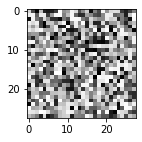

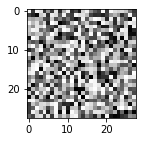

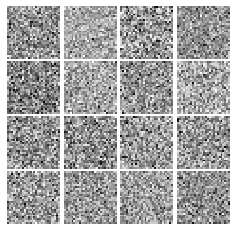

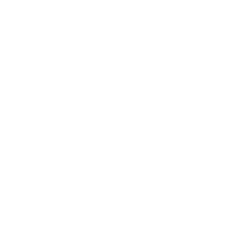

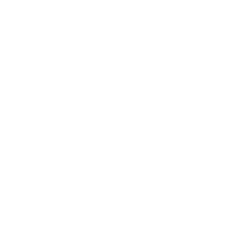

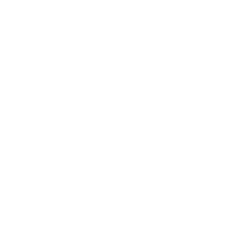

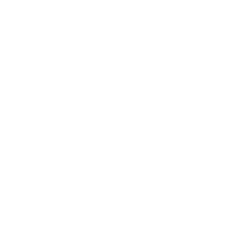

In [82]:
gan=NeuralNetwork([784,128,686,10])
gan.train(x_training2, y_training2, 100, 50,  0.1, 0.9,0.999,0.00000001)